# Word2vec analysis of headlines on [StreetEYE](http://www.streeteye.com)

This is a fun mad science experiment in natural language processing, an implementation in Tensorflow of a word embedding model similar to [word2vec](https://en.wikipedia.org/wiki/Word2vec), and an application to the headlines on StreetEYE, a social news aggregator which finds the most shared headlines by the most influential social media accounts and blogs. 

The output is a semantic representation of the most common words and n-grams as 128-vectors of floats, which shows that the algorithm gains a pretty good understanding of which words generally arise in similar contexts and hence have strongly related meanings.

We can visualize the vocabulary space, showing which words are similar, we can show that interesting abstractions emerge (i.e., Germany + chaos = France), and we can use the generated vectors to better predict which headlines will be relevant and likely to be widely shared.

This implementation is based on the text embedding module in the [Udacity Deep Learning MOOC](https://www.udacity.com/course/deep-learning--ud730) - examples [here](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/5_word2vec.ipynb).


In [1]:
#imports
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import pickle

import zipfile
import tensorflow as tf
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

%matplotlib inline


In [2]:
############################################################
# read data file - a complete corpus of headlines
# headlines have been processed using Wordnet lemmatizer,
# and popular n-grams have been combined
############################################################

def read_data(filename):
  """Extract the file as a list of words"""
  with open(filename) as f:
    data = tf.compat.as_str(f.read()).split()
  return data

filename = "headline_lemmatized.txt"
words = read_data(filename)
print('Data size %d' % len(words))



Data size 4945778


In [3]:
############################################################
# build dataset
############################################################

vocabulary_size = 20000 # picked to have ~10 occurrences for least popular

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:100])
print("\n")
print('Least common words', count[-10:])
print("\n")
print('Sample data', data[:100])



Most common words (+UNK) [['UNK', 243648], ('with', 33616), ('us', 25968), ('from', 24857), ('new', 23472), ('say', 22460), ('how', 22404), ('have', 20555), ('trump', 19880), ('do', 16386), ('you', 16223), ('why', 16110), ('china', 16080), ('what', 15115), ('about', 14978), ('year', 14635), ('after', 14589), ('will', 14125), ('2016', 13612), ('over', 13415), ('not', 13292), ('that', 13070), ('up', 12910), ('more', 12708), ('get', 12361), ('pdf', 12324), ('market', 12104), ('this', 12054), ('donald_trump', 11691), ('its', 11624), ('make', 11623), ('your', 11135), ('big', 10689), ('world', 10352), ('2015', 10348), ('out', 10118), ('time', 10029), ('plan', 9685), ('bank', 9475), ('video', 9012), ('can', 8849), ('news', 8809), ('report', 8504), ('obama', 8421), ('take', 8379), ('go', 8176), ('who', 8082), ('one', 8014), ('deal', 7951), ('first', 7897), ('than', 7510), ('his', 7468), ('show', 7415), ('million', 7356), ('could', 7297), ('all', 7227), ('woman', 7223), ('day', 7220), ('oil', 7

In [4]:
############################################################
# function to generate mini batches
############################################################

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])



data: ['analyst', 'say', 'politics', 'hold', 'up', 'greece', 'debt', 'deal']

with num_skips = 2 and skip_window = 1:
    batch: ['say', 'say', 'politics', 'politics', 'hold', 'hold', 'up', 'up']
    labels: ['politics', 'analyst', 'say', 'hold', 'up', 'politics', 'hold', 'greece']

with num_skips = 4 and skip_window = 2:
    batch: ['politics', 'politics', 'politics', 'politics', 'hold', 'hold', 'hold', 'hold']
    labels: ['analyst', 'up', 'say', 'hold', 'say', 'greece', 'politics', 'up']


In [6]:
############################################################
# set up computation graph
############################################################

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 20 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'): 
  # unsure why I have to pin to CPU to make it work
  # somewhat defeats the purpose of tensorflow if you can't use GPU

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  tf_learning_rate = tf.placeholder(tf.float32)

  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(tf_learning_rate).minimize(loss)

  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))


In [9]:
############################################################
# run computation graph
############################################################

num_steps = 200001

# high initial learning rate, reduce gradually
initial_lr = 1.0
final_lr = 0.1
lr_reduce_rate=(final_lr / initial_lr) ** (1.0/num_steps)
print("lr_reduce_rate: %.10f" % lr_reduce_rate)

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  lr = initial_lr

  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels,
                tf_learning_rate : lr,}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict,
)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
    lr *= lr_reduce_rate
    
  final_embeddings = normalized_embeddings.eval()


lr_reduce_rate: 0.9999884872
Initialized
Average loss at step 0: 5.752457
Nearest to iran: enrollment, replacement, metal, fulfil, laziness, waste, long_term, permissionless,
Nearest to over: banks, taxprof, joes, preach, gut, rebranding, latin, holly,
Nearest to show: self, aso, gigabit, accomplishment, florida, admirer, eurex, plaid,
Nearest to donald_trump: mug, purse, macedonia, replication, emotional, flyer, rescue, barometer,
Nearest to 2016: effectively, thankful, blame, endorser, hoverboard, successor, api, unusually,
Nearest to his: irrational, coo, converse, apres, kay, clint, ahn, rising,
Nearest to this: mow, shelling, ultimately, transformer, overstock, torpedo, pokemon, duhigg,
Nearest to rise: restore, immortality, lawsuit, alzheimers, witch, challenged, pares, seeking,
Nearest to than: thwart, childbirth, follows, innovative, berenberg, milky, spur, parallel,
Nearest to want: reno, luc, pugh, tableau, using, natural, khorasan, curiosity,
Nearest to global: frank, elabor

# Visualize output

We have 128-vectors of floating points. An interesting question is how one
can represent a set of vectors on a 2D graph in such a way that the 2-norm
distance is preserved as well as possible. This is similar to map projections,
although the surface of a sphere is already 2-dimensional, 2 coordinates are
needed to describe a point. In the more general case, one approach would be to 
do principal components analysis to, identify the 2 dimensions which capture 
the most variation, and ignore the rest. A more sophisticated
approach is [TSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), 
which doesn't throw away the data in the remaining dimensions and is
designed to yield a better result.

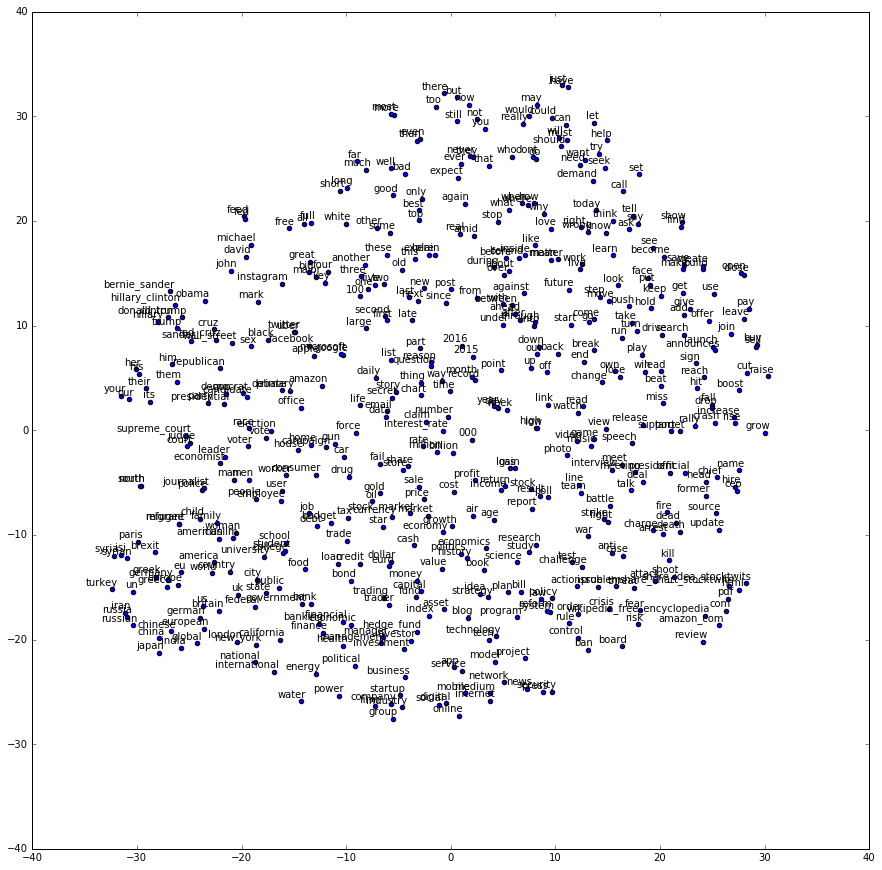

In [10]:
############################################################
# plot in 2D, after transforming 128-vectors with TSNE
############################################################

num_points = 500

tsne = TSNE(perplexity=30,
            n_components=2,
            init='pca',
            n_iter=5000)

two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)


TODO: list some interesting relationships between embeddings

In [15]:
###########################################################
# list collocated words
# allows us to add mappings for common phrases)
############################################################

import operator
import nltk
from nltk.collocations import *
with open('headline_lemmatized.txt', 'r') as myfile:
        data = myfile.read()
# trigrams with at least 500 occurrences       
tokens = nltk.word_tokenize(data)
finder = TrigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(500)
z = finder.ngram_fd.viewitems()
sorted(z, key=operator.itemgetter(1), reverse=True)

# bigrams with at least 1000 occurrences       
finder = BigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(1000)
z = finder.ngram_fd.viewitems()
sorted(z, key=operator.itemgetter(1), reverse=True)




[(('more', 'than'), 2371),
 (('year', 'old'), 1504),
 (('amazon_com', 'book'), 1496),
 (('fred', 'economic_data'), 1475),
 (('this', 'year'), 1263),
 (('oil', 'price'), 1209),
 (('social', 'medium'), 1195),
 (('iran', 'deal'), 1157),
 (('you', 'need'), 1095),
 (('what', 'do'), 1080),
 (('news', 'from'), 1073),
 (('know', 'about'), 1065),
 (('deal', 'with'), 1049),
 (('first', 'time'), 1025),
 (('paris', 'attack'), 1018),
 (('here', 'what'), 1017),
 (('plan', 'parenthood'), 1005),
 (('must', 'read'), 1000)]

In [16]:
############################################################
# dump pickle file of embeddings
############################################################


mydict = {}
myreverse = {}

for i in range(vocabulary_size):
    k = reverse_dictionary[i]
    e = final_embeddings[i]
    mydict[k]=i
    myreverse[i]=k

pickle_list = [mydict, myreverse, final_embeddings]

output = open('embeddings.pkl', 'wb')
pickle.dump(pickle_list, output)
output.close()
